# PeakAffectDS Analysis

### Load Libraries

Here the relevant libraries needed to properly analyze the data are loaded. The Pandas library is used to load the data into dataframes.

In [128]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Import Data

In [2]:
happy = pd.read_csv('Data/Raw_PID_01-10/01/01-03-01.csv')
print('rows =', len(happy.index))
happy.head()

rows = 390568


,Time,EMG_zyg,EMG_cor,ECG,Respiration,Events
0,0.0005,-0.048828,-0.057068,-0.170288,-0.065918,0.0
1,0.0010,-0.031433,-0.043030,-0.169067,-0.065308,0.0
2,0.0015,-0.002136,-0.024414,-0.169983,-0.065002,0.0
3,0.0020,0.030212,-0.003357,-0.172424,-0.064392,0.0
4,0.0025,0.040894,0.010681,-0.174866,-0.063782,0.0


### Exploring The Data

Now the data can be used to make a power spectrum graph. Here, a graph is made using the `np.fft.fft()` function. Note that the resulting graph will be mirrored at `Frequency=0`, all frequencies less than 0 are removed.

In [63]:
#
# Creates a dataframe of power spectrum information given a series of
# voltage values and the time step between each value
#

def makePowerSpectrum(data, time_step):
    mags = np.abs(np.fft.fft(data)) ** 2
    freqs = np.fft.fftfreq(data.size, time_step)
    idx = np.argsort(freqs)
    ps = pd.DataFrame({'Frequency': freqs[idx], 'Magnitude': mags[idx]})
    
    # Remove mirrored frequencies
    ps = ps[ps['Frequency'] >= 0]
    
    return ps

In [64]:
#
# Looks at the shape of the data
#

ps = makePowerSpectrum(happy['EMG_zyg'], 0.0005)
print('rows =', len(ps))
ps.head()

rows = 195284


,Frequency,Magnitude
195284,0.000000,78327.384986
195285,0.005121,166.548020
195286,0.010241,965.221469
195287,0.015362,495.377823
195288,0.020483,435.852112


Text(0.5, 1.0, 'Power Spectrum of EMG_zyg')

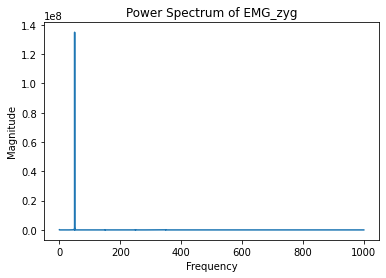

In [65]:
#
# Plots the power spectrum for EMG_zyg
#

plt.plot(ps['Frequency'], ps['Magnitude'])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Power Spectrum of EMG_zyg')

This graph shows that there are massive spikes in the power at the 50 Hz range, as expected. This is being caused by noise introduced by the device's power source during the recordings.

The shape of the data shows that there are many more rows than frequencies. This means each entry does not vary by 1 Hz, but rather a fraction of 1 Hz.

In the next graph, the frequencies greater than 55 are plotted to show a better sense of what the graph looks like while avoiding the noise introduced:

Text(0, 0.5, 'Magnitude')

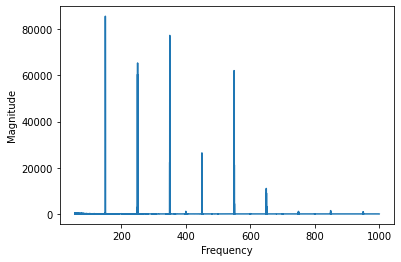

In [66]:
#
# Ensuring the data still looks good despite noise
#

upper_ps = ps[ps['Frequency'] >= 55]

plt.plot(upper_ps['Frequency'], upper_ps['Magnitude'])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

Now that the noise is not shown, the key frequencies affecting the EMG can be seen, validating that the function works properly. The following graphs show the power spectrum graphs for the remaining columns: `EMG_cor`, `EMC` and `Respiration`.

Text(0.5, 1.0, 'Power Spectrum of EMG_cor')

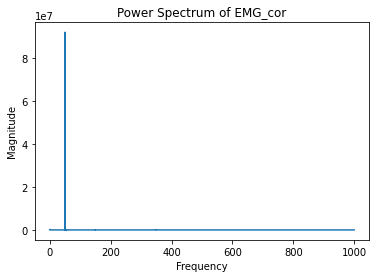

In [67]:
#
# Plots the power spectrum for EMG_cor
#

ps = makePowerSpectrum(happy['EMG_cor'], 0.0005)
plt.plot(ps['Frequency'], ps['Magnitude'])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Power Spectrum of EMG_cor')

Text(0.5, 1.0, 'Power Spectrum of ECG')

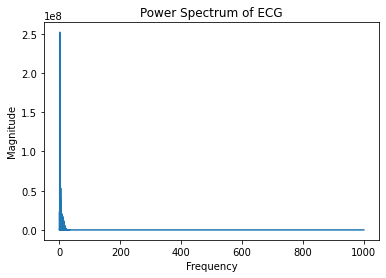

In [68]:
#
# Plots the power spectrum for ECG
#

ps = makePowerSpectrum(happy['ECG'], 0.0005)
plt.plot(ps['Frequency'], ps['Magnitude'])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Power Spectrum of ECG')

Text(0.5, 1.0, 'Power Spectrum of Respirator')

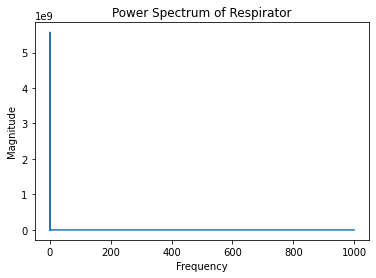

In [69]:
#
# Plots the power spectrum for Respirator
#

ps = makePowerSpectrum(happy['Respiration'], 0.0005)
plt.plot(ps['Frequency'], ps['Magnitude'])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Power Spectrum of Respirator')

### Validating findings

The following code is to check if the other data available looks the same:

In [72]:
happy2 = pd.read_csv('Data/Raw_PID_01-10/02/02-03-02.csv')
print('rows =', len(happy2.index))
happy2.head()

rows = 740037


,Time,EMG_zyg,EMG_cor,ECG,Respiration,Events
0,0.0005,0.038147,0.025330,0.236511,-0.601196,0.0
1,0.0010,0.033569,0.019226,0.238342,-0.601196,0.0
2,0.0015,0.034485,0.014343,0.240479,-0.601196,0.0
3,0.0020,0.052185,0.019836,0.242615,-0.601196,0.0
4,0.0025,0.049133,0.016479,0.244751,-0.601196,0.0


Text(0.5, 1.0, 'Power Spectrum of ECG')

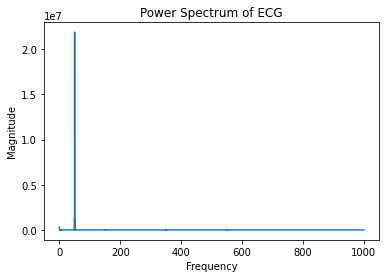

In [73]:
ps = makePowerSpectrum(happy2['EMG_zyg'], 0.0005)
plt.plot(ps['Frequency'], ps['Magnitude'])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Power Spectrum of ECG')

Text(0, 0.5, 'Magnitude')

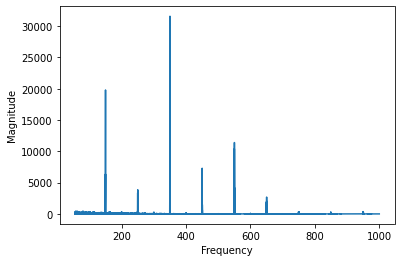

In [142]:
upper_ps = ps[ps['Frequency'] >= 55]

plt.plot(upper_ps['Frequency'], upper_ps['Magnitude'])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

### Removing Noise

The resulting power spectrum reveals that there is noise in the 50 Hz range that needs to be removed. This can be taken care of using a notch filter using Scipy.

465.6971534565705


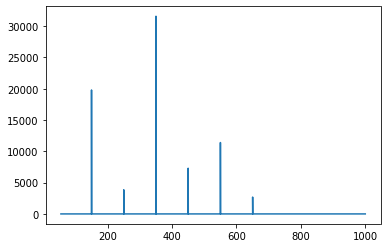

In [192]:
#
# Experimental code to get the local maximums of the data
#

def getLocalMax(vals, r=10000):
    # A value is a local max if it is:
    # 1. Larger than the mean value
    # 2. Larger than the nearby values around it
    suppressed = np.copy(vals)
    val_mean = np.mean(vals)
    print(24*val_mean)
    
    for i in range(len(vals)):
        if vals[i] > val_mean * 25:
            val = vals[i]
            left = max(i - r, 0)
            right = min(i + r, len(vals) - 1)
            
            for k in range(left, right + 1):
                if k != i and vals[k] > val:
                    suppressed[i] = 0
                    #print("nearby max")
                    break
                        
        else:
            suppressed[i] = 0
    return suppressed
                    
test = getLocalMax(list(upper_ps['Magnitude']))
plt.plot(upper_ps['Frequency'], test)

In [196]:
test_ps = upper_ps[test > 0]
test_ps.head()

,Frequency,Magnitude
425530,150.024931,19793.521314
462566,250.117224,3854.008190
499586,350.166275,31569.726248
536580,450.145060,7292.898312
573609,550.218435,11398.571671


In [111]:
for i in range(10):
    for j in range(5):
        k = i - 2 + j
        if k >= 0 and k <= 10:
            print(i - 2 + j)
    print()

0
1
2

0
1
2
3

0
1
2
3
4

1
2
3
4
5

2
3
4
5
6

3
4
5
6
7

4
5
6
7
8

5
6
7
8
9

6
7
8
9
10

7
8
9
10



Resources
- https://www.geeksforgeeks.org/design-an-iir-notch-filter-to-denoise-signal-using-python/